In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
# Set file path
data_path = "financial_data/"

# Load Aker BP Weekly Data (Dependent Variable)
aker_bp_weekly = pd.read_csv(data_path + "Aker_BP_weekly.csv", parse_dates=["Date"], index_col="Date")

# Load Independent Variables (Exogenous)
oil_prices = pd.read_csv(data_path + "Brent_Crude.csv", parse_dates=["Date"], index_col="Date")
cpi_rate = pd.read_csv(data_path + "CPI_Rate_weekly.csv", parse_dates=["Date"], index_col="Date")
nok_usd = pd.read_csv(data_path + "NOK_USD_weekly.csv", parse_dates=["Date"], index_col="Date")
policy_rate = pd.read_csv(data_path + "Norwegian_Policy_Rate_weekly.csv", parse_dates=["Date"], index_col="Date")
osebx = pd.read_csv(data_path + "OSEBX_weekly.csv", parse_dates=["Date"], index_col="Date")
us_treasury = pd.read_csv(data_path + "US_10Yr_Treasury_weekly.csv", parse_dates=["Date"], index_col="Date")

In [30]:
import pandas as pd

# Set file path
data_path = "financial_data/"

# Function to load weekly data and convert "YYYY-WW" format to datetime (Monday of the week)
def load_weekly_data(filename, value_col):
    df = pd.read_csv(data_path + filename)
    
    # Convert "YYYY-WW" format to datetime (Monday of each week)
    df['Date'] = pd.to_datetime(df['Date'] + '-1', format='%Y-%W-%w')

    # Set Date as index
    df.set_index('Date', inplace=True)

    # Keep only the relevant column
    df = df[[value_col]]
    
    return df

# Load datasets with proper datetime indexing
aker_bp_weekly = load_weekly_data("Aker_BP_weekly.csv", "Log_Returns")
oil_prices = load_weekly_data("Brent_Crude_weekly.csv", "Close")
cpi_rate = load_weekly_data("CPI_Rate_weekly.csv", "Rate")
nok_usd = load_weekly_data("NOK_USD_weekly.csv", "Close")
policy_rate = load_weekly_data("Norwegian_Policy_Rate_weekly.csv", "Rate")
osebx = load_weekly_data("OSEBX_weekly.csv", "Close")
us_treasury = load_weekly_data("US_10Yr_Treasury_weekly.csv", "Close")

# Merge datasets using outer join to retain all dates
merged_df = aker_bp_weekly.copy()

# Dictionary of exogenous variables
exogenous_vars = {
    "Oil_Price": oil_prices,
    "CPI_Rate": cpi_rate,
    "NOK_USD": nok_usd,
    "Policy_Rate": policy_rate,
    "OSEBX": osebx,
    "US_Treasury": us_treasury
}

# Merge all datasets
for var_name, df in exogenous_vars.items():
    merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')
    merged_df.rename(columns={df.columns[0]: var_name}, inplace=True)  # Rename for clarity

# Remove duplicate dates (if any)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Reindex to keep the original weekly timestamps
merged_df = merged_df.reindex(aker_bp_weekly.index)  # Ensure all dates match Aker BP weekly data

# Fill missing values
merged_df.ffill(inplace=True)  # Forward-fill missing values
merged_df.bfill(inplace=True)  # Backward-fill as a fallback

# Check for any remaining NaNs
print("\nMissing values after filling:")
print(merged_df.isnull().sum())

# Display first few rows
print(merged_df.head())



Missing values after filling:
Log_Returns    0
Oil_Price      0
CPI_Rate       0
NOK_USD        0
Policy_Rate    0
OSEBX          0
US_Treasury    0
dtype: int64
            Log_Returns   Oil_Price  CPI_Rate   NOK_USD  Policy_Rate  \
Date                                                                   
2014-01-06    -0.006842  107.334999  0.337481  6.116680          0.5   
2014-01-13    -0.004474  106.974001  0.337481  6.171990          0.5   
2014-01-20     0.006296  106.883998  0.337481  6.131296          0.5   
2014-01-27    -0.004124  107.909999  0.337481  6.151404          0.5   
2014-02-03    -0.003896  107.260001  0.253927  6.161598          0.5   

                 OSEBX  US_Treasury  
Date                                 
2014-01-06  601.049988      2.99000  
2014-01-13  604.642004      2.94280  
2014-01-20  616.578003      2.85000  
2014-01-27  614.601990      2.79825  
2014-02-03  595.230005      2.70960  


                               SARIMAX Results                                
Dep. Variable:            Log_Returns   No. Observations:                  521
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1484.003
Date:                Thu, 20 Mar 2025   AIC                          -2950.006
Time:                        11:34:39   BIC                          -2911.756
Sample:                    01-06-2014   HQIC                         -2935.020
                         - 12-25-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Oil_Price    1.525e-05      0.000      0.080      0.936      -0.000       0.000
CPI_Rate       -0.0145      0.014     -1.010      0.313      -0.043       0.014
NOK_USD         0.0123      0.004      3.100    

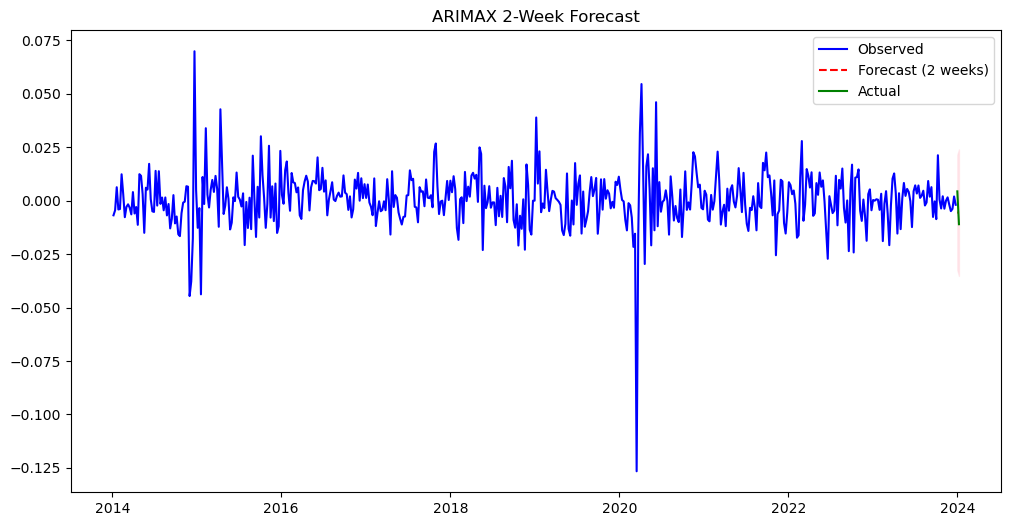


 Performance for 5-week Forecast:
  - MSE: 0.0001
  - MAE: 0.0065
  - MAPE: 100.34%
  - R² Score: -0.1186


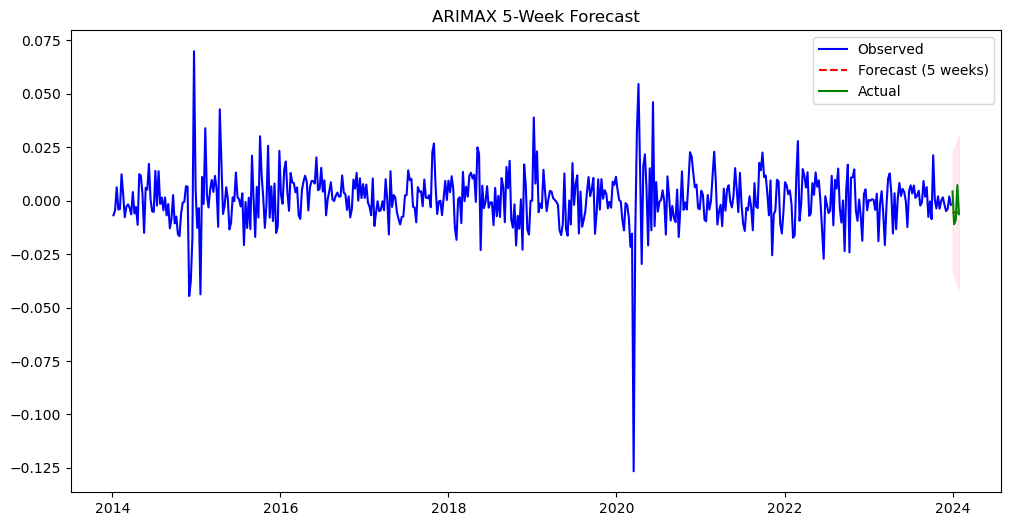


📊 Performance Summary for Different Forecast Horizons:
   Horizon       MSE       MAE        MAPE  R² Score
0        2  0.000063  0.007621  137.333725 -0.066948
1        5  0.000061  0.006480  100.341832 -0.118565


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure proper datetime format in index
merged_df.index = pd.to_datetime(merged_df.index)

# **Fix: Remove Duplicate Dates**
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# **Fix: Explicitly set weekly frequency to MONDAY**
merged_df = merged_df.asfreq('W-MON')  

# Fill any remaining missing values
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Define time range for training
train_end = "2023-12-31"

# Split dataset into train & test sets
train_data = merged_df.loc[:train_end]
test_data = merged_df.loc[train_end:]  # Keep test data for performance evaluation

# Define dependent (target) and exogenous (independent) variables
Y_train = train_data['Log_Returns']
X_train = train_data[['Oil_Price', 'CPI_Rate', 'NOK_USD', 'Policy_Rate', 'OSEBX', 'US_Treasury']].copy()

# Ensure exogenous variables have no missing values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)  
X_train.ffill(inplace=True)  
X_train.bfill(inplace=True)  

# Ensure Y_train is aligned with X_train
Y_train = Y_train.loc[X_train.index]

# Define ARIMAX order
order = (1, 1, 1)  

# Train ARIMAX model
model = SARIMAX(Y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print model summary
print(results.summary())

# **Prediction Horizons: 2 and 5*
forecast_horizons = [2, 5]
performance_metrics = []

for forecast_steps in forecast_horizons:
    # Generate forecast index
    forecast_dates = pd.date_range(start=train_data.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W-MON')

    # Use the last known exogenous values for forecasting
    future_exog_df = pd.DataFrame(
        np.tile(X_train.iloc[-1].values, (forecast_steps, 1)),  # Repeat last known values
        index=forecast_dates,
        columns=X_train.columns
    )

    # Generate forecasts
    forecast = results.get_forecast(steps=forecast_steps, exog=future_exog_df)

    # Extract predicted values and confidence intervals
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_dates)
    forecast_df['Lower CI'] = forecast_ci.iloc[:, 0]
    forecast_df['Upper CI'] = forecast_ci.iloc[:, 1]

    # Compare to actual values if available
    if forecast_dates[-1] in test_data.index:
        actual_values = test_data.loc[forecast_dates, 'Log_Returns']
        
        # Compute error metrics
        mse = mean_squared_error(actual_values, forecast_mean)
        mae = mean_absolute_error(actual_values, forecast_mean)
        mape = np.mean(np.abs((actual_values - forecast_mean) / actual_values)) * 100  # Percentage error
        r2 = r2_score(actual_values, forecast_mean)
        
        performance_metrics.append({
            'Horizon': forecast_steps,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'R² Score': r2
        })

        # Print metrics
        print(f"\n Performance for {forecast_steps}-week Forecast:")
        print(f"  - MSE: {mse:.4f}")
        print(f"  - MAE: {mae:.4f}")
        print(f"  - MAPE: {mape:.2f}%")
        print(f"  - R² Score: {r2:.4f}")

    # **Plot results**
    plt.figure(figsize=(12, 6))
    
    # Plot observed log-returns
    plt.plot(train_data.index, train_data['Log_Returns'], label='Observed', color='blue')

    # Plot forecast results
    plt.plot(forecast_df.index, forecast_df['Forecast'], label=f'Forecast ({forecast_steps} weeks)', linestyle='dashed', color='red')
    plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)

    # Plot actual values if available
    if forecast_dates[-1] in test_data.index:
        plt.plot(test_data.loc[forecast_dates].index, test_data.loc[forecast_dates, 'Log_Returns'], label='Actual', color='green')

    plt.legend()
    plt.title(f'ARIMAX {forecast_steps}-Week Forecast')
    plt.show()

# **Display Performance Metrics**
performance_df = pd.DataFrame(performance_metrics)
print("\n📊 Performance Summary for Different Forecast Horizons:")
print(performance_df)
